# Compact Finite Difference Scheme

## Learning Outcomes

This examples teaches how to compute derivative of a function using Compact Finite Difference scheme as described in the paper by [Lele](https://www.sciencedirect.com/science/article/abs/pii/002199919290324R).

In this example, you will learn:
* how to convert stencil expressions from discretization to NumPy slicing operations
* how to create a tridiagonal matrix (dense)
* how to solve the resulting tridiagonal matrix using `linalg.solve`
* how to compute the L2 norm error between exact solution and computed solution using `linalg.norm`

Note that a more optimal way of solving tridiagonal matrices is by using the TDMA algorithm. Here, we show how this can be solved using NumPy's `solve` API.

---

## Background

Compact finite difference schemes approximate the first derivative by including the information of derivative of function at neighboring points in addition to including the value of function themselves, as shown below:

$\alpha f^{'}_{i-1} + f^{'}_{i-1} + \alpha f^{'}_{i+1} = a_{1} f_{j+1} + a_{2} f_{j+2} - a_{2} f_{j-2} - a_{1} f_{j-1}$

This can be represented more compactly in the following form,\
$\mathbf{A} f' = \mathbf{B} f$

where the matrix $\mathbf{A}$ is tridiagonal and $\mathbf{B}$ is pentadiagonal. In this example, we store the matrix, $\mathbf{A}$, as a dense matrix and explicitly compute $\mathbf{B} f$ instead of storing B to save memory. To compute the derivative, $f'$, of a function, $f$, using a sixth order compact finite difference, we solve a linear system of equations

The main and off-diagonal elements of matrix $\mathbf{A}$ are 1.0 and 1.0/3 respectively. For this example, we consider a sine function, $f=\sin({k x})$


---

The domain extends from 0 to $2 \pi$ and is discretized using N points. Since the stecil for the RHS extends 2 points on either side, we may have to create arrays of size (N+4) to accomodate storing the values of points outside the domain.

## Implementation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# number of points used in discretization
npoints: int = 100

# number of stencil points to compute the right-hand side
n_stencil: int = 2

# length of the domain
length = 2.0*np.pi

# wavenumber of the initial profile
wavenumber = 10

In [3]:
# compute the spacing
h = length/npoints

# generate the discretized points
x = np.linspace(0, length, npoints, endpoint=False)

# compute the function and exact derivative
f_interior = np.sin(wavenumber*x)
derivative_exact = wavenumber* np.cos(wavenumber*x)

In [4]:
# For sixth order, the stencil should be of size 2
assert n_stencil == 2

Compute the function values including the left and right-hand side boundaries

In [5]:
function_values = np.zeros(npoints + n_stencil*2)
function_values[n_stencil:-n_stencil] = f_interior

# set the RHS boundary values using periodic boundary condition
function_values[npoints + n_stencil] = f_interior[0]
function_values[npoints + n_stencil + 1] = f_interior[1]

# set the LHS boundary values using periodic boundary condition
function_values[0] = f_interior[npoints - n_stencil]
function_values[1] = f_interior[npoints - n_stencil + 1]

Form the matrix $\mathbf{A}$

In [6]:
A = np.zeros((npoints, npoints))

# Eqn (2.1.7) from Compact Finite Difference with Spectral-like Accuracy, Lele, 1992, JCP.
alpha = 1.0/3.0

# generate the tridiagonal matrix using np.diag
main = np.ones((1, npoints))[0]
diagonal = alpha*np.ones((1, npoints - 1))[0]
A = np.diag(main, 0) + np.diag(diagonal, -1) + np.diag(diagonal, 1)

# Apply periodic boundary condition
A[0, -1] = alpha
A[-1, 0] = alpha

Form the right-hand side

In [7]:
# Generate the right-hand side
a1 = 7.0/(9.0*h)
a2 = 1.0/(36.*h)

# note how $a_{1} f_{j+1} + a_{2} f_{j+2} - a_{2} f_{j-2} - a_{1} f_{j-1}$
# gets converted to slicing operations on the array function_values.

# It is important to derive the right start and end indices for the slices corresponding to each term.
# Since the stencil size on the RHS is 2 (n_stencil), the index j in the equation starts from the second point (j=2)
# and ends at j=(npoints+2). This translates to the following slices;

# f_{j+2} - f_{j-2} -> (function_values[4:npoints+4] - function_values[0:npoints])
# f_{j+1} - f_{j-1} -> (function_values[3:npoints+3] - function_values[1:npoints+1])
rhs = np.zeros(npoints)
rhs[0:npoints] = a1*(function_values[3:npoints+3] - function_values[1:npoints+1]) \
               + a2*(function_values[4:npoints+4] - function_values[0:npoints])

Compute the derivative and the L2 norm error

In [8]:
derivative = np.linalg.solve(A, rhs)
error = np.linalg.norm(derivative - derivative_exact)
print(f"L2 norm error: {error}")

L2 norm error: 0.0021705301478625403


---
Compare the exact and computed derivative of the function

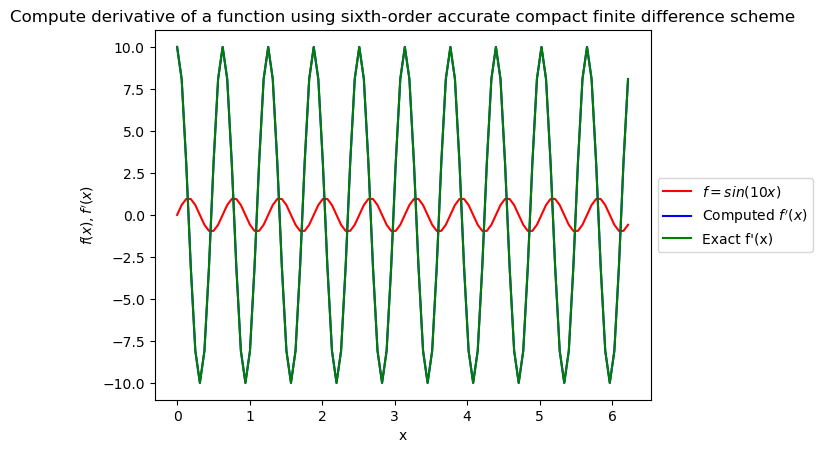

In [9]:
plt.plot(x, f_interior, color='red', label=f'$f = sin({wavenumber}x)$')
plt.plot(x, derivative, color='blue', label=f'Computed $f\'(x)$')
plt.plot(x, derivative_exact, color='green', label=f'Exact f\'(x)')

plt.xlabel(f'x')
plt.ylabel(f'$f(x), f\'(x)$')
plt.title(f'Compute derivative of a function using sixth-order accurate compact finite difference scheme')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We see that the curves for the computed and the exact derivative overlap (green and blue) and the L2 error is of the order of 1e-3. If you are curious,

* Try increasing the wavenumber, $k$, to see how this affects the accuracy of the solution. Plot error vs wavenumber to see how it varies
* Try reducing the resolution of the grid (n_points) and plot the error vs number of points.
* Try plotting the modified wavenumber and see if you can match the curve in the paper by [Lele](https://www.sciencedirect.com/science/article/abs/pii/002199919290324R).